In [1]:
import os
import glob
import hydromt
from hydromt import DataCatalog
import xarray as xr
import numpy as np
from os.path import join
import geopandas as gpd
import pandas as pd
from hydromt_sfincs import SfincsModel, utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors, patheffects
from string import ascii_lowercase as abcd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from matplotlib.ticker import FormatStrFormatter

In [2]:
work_dir = r'Z:\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\03_OBS\analysis_2'
out_dir = os.path.join(work_dir, 'ensemble_mean')
if os.path.exists(out_dir) is False:
    os.makedirs(out_dir)
os.chdir(out_dir)

In [3]:
# Load a SFINCS model and get elevation
yml_base = r'Z:\users\lelise\data\data_catalog_BASE_Carolinas.yml'
root = r'Z:\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\01_AGU2023\future_florence\future_florence_ensmean'
mod = SfincsModel(root=root, mode='r', data_libs=[yml_base])
dep = mod.grid['dep']

In [4]:
# Load coastal waterbody shapefile
coastal_wb = mod.data_catalog.get_geodataframe('carolinas_coastal_wb')
coastal_wb = coastal_wb.to_crs(mod.crs)
coastal_wb_clip = coastal_wb.clip(mod.region)

In [5]:
da_zsmax = xr.open_dataarray(os.path.join(work_dir, 'zsmax', f'pgw_zsmax.nc'))
da_classified = xr.open_dataarray(os.path.join(work_dir, 'driver_analysis', f'pgw_drivers_classified_all.nc'))

In [7]:
storms = ['flor', 'floy', 'matt']
scenarios = ['coastal', 'runoff', 'compound']
ds_wl_diff = []
run_ids = []
for storm in storms:
    # There is only one 'present' scenario that is compared to the ensemble of future
    pres_wl = da_zsmax.sel(run=f'{storm}_pres_compound') 
    pres_drivers = da_classified.sel(run=f'{storm}_pres')

    # Now we loop through all the future runs for each storm to compare with the present above
    nruns = 8
    if storm == 'matt':
        nruns = 7
    for sf in np.arange(1, nruns, 1):
        for slr in np.arange(1, 6, 1):
            fut_run_id = f'{storm}_fut_SF{sf}_SLR{slr}'
            fut_wl = da_zsmax.sel(run=f'{fut_run_id}_compound')
            fut_drivers = da_classified.sel(run=fut_run_id)

            # No Flood = 0, Coastal = 1, Compound-coastal = 2, Runoff = 3, Compound-runoff = 4
            for scenario in scenarios:
                if scenario == 'coastal':
                    mask_pres = xr.where((pres_drivers == 1), True, False)
                    mask_fut = xr.where((fut_drivers == 1), True, False)
                elif scenario == 'runoff':
                    mask_pres = xr.where((pres_drivers == 3), True, False)
                    mask_fut = xr.where((fut_drivers == 3), True, False)
                else:
                    # Combine into a single 'compound' classification
                    mask_pres = xr.where((pres_drivers == 2) | (pres_drivers == 4), True, False)
                    mask_fut = xr.where((fut_drivers == 2) | (fut_drivers == 4), True, False)

                # Use the mask for each process to calculate the flood depths from the water level and elevation
                # In the PRESENT
                depth_pres = (pres_wl.where(mask_pres) - dep).compute()
                depth_pres = depth_pres.where(depth_pres > 0.05)
                depth_pres.name = f'{storm}_pres_{scenario}'
                
                # In the FUTURE
                depth_fut = (fut_wl.where(mask_fut) - dep).compute()
                depth_fut = depth_fut.where(depth_fut > 0.05)
                depth_fut.name = f'{storm}_fut_SF{sf}_SLR{slr}_{scenario}'
                
                # Now calculate the difference in flood depths in the future for each process
                diff = (depth_fut.fillna(0) - depth_pres.fillna(0)).compute()
                diff.name = f'WLdiff_{storm}_fut_SF{sf}_SLR{slr}_{scenario}'
                ds_wl_diff.append(diff)
                run_ids.append(diff.name)

# Concatenate the data arrays
ds_wl_diff = xr.concat(ds_wl_diff, dim='run')
ds_wl_diff['run'] = xr.IndexVariable('run', run_ids)

print(ds_wl_diff['run'].values)

['WLdiff_flor_fut_SF1_SLR1_coastal' 'WLdiff_flor_fut_SF1_SLR1_runoff'
 'WLdiff_flor_fut_SF1_SLR1_compound' 'WLdiff_flor_fut_SF1_SLR2_coastal'
 'WLdiff_flor_fut_SF1_SLR2_runoff' 'WLdiff_flor_fut_SF1_SLR2_compound'
 'WLdiff_flor_fut_SF1_SLR3_coastal' 'WLdiff_flor_fut_SF1_SLR3_runoff'
 'WLdiff_flor_fut_SF1_SLR3_compound' 'WLdiff_flor_fut_SF1_SLR4_coastal'
 'WLdiff_flor_fut_SF1_SLR4_runoff' 'WLdiff_flor_fut_SF1_SLR4_compound'
 'WLdiff_flor_fut_SF1_SLR5_coastal' 'WLdiff_flor_fut_SF1_SLR5_runoff'
 'WLdiff_flor_fut_SF1_SLR5_compound' 'WLdiff_flor_fut_SF2_SLR1_coastal'
 'WLdiff_flor_fut_SF2_SLR1_runoff' 'WLdiff_flor_fut_SF2_SLR1_compound'
 'WLdiff_flor_fut_SF2_SLR2_coastal' 'WLdiff_flor_fut_SF2_SLR2_runoff'
 'WLdiff_flor_fut_SF2_SLR2_compound' 'WLdiff_flor_fut_SF2_SLR3_coastal'
 'WLdiff_flor_fut_SF2_SLR3_runoff' 'WLdiff_flor_fut_SF2_SLR3_compound'
 'WLdiff_flor_fut_SF2_SLR4_coastal' 'WLdiff_flor_fut_SF2_SLR4_runoff'
 'WLdiff_flor_fut_SF2_SLR4_compound' 'WLdiff_flor_fut_SF2_SLR5_coastal'
 'WLdi

In [9]:
# Loop through each storm and scenario and take the average difference
# THIS SCRIPT TAKES THE MEAN ACROSS THE ENSEMBLE AT EACH CELL TO GET A
# MEAN DEPTH SURFACE. THIS CAN BE COMPARED TO COMPILING ALL THE FLOOD DEPTHS FOR EACH SCENARIO (E.G., STORM, CLIMATE)
# AND CREATING A DISTRIBUTION TO EXTRACT DEPTH STATISTICS.
mean_wl_diff = []
for storm in storms:
    storm_runs = [i for i in run_ids if f'{storm}' in i]
    for scenario in scenarios:
        # Select the runs for each storm and scenario (e.g., process)
        storm_scen_runs = [i for i in storm_runs if f'{scenario}' in i]

        # Calculate the mean difference in max depth between the future and present for each ensemble member
        m = ds_wl_diff.sel(run=storm_scen_runs).mean(dim='run')
        m.name = f'WLdiff_{storm}_{scenario}'
        mean_wl_diff.append(m)
        # m.raster.to_raster(os.path.join(os.getcwd(), f'WLdiff_{storm}_{scenario}.tif'), nodata=0.0)

In [12]:
mean_dep_stats = pd.DataFrame()
for ds in mean_wl_diff:
    ds = xr.where(ds <= 0, np.nan, ds)  # get rid of points that are less than or equal to zero for this calculation
    df = ds.to_dataframe().dropna(how='any', axis=0)
    df = df.drop(columns='spatial_ref')
    df_stats = df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
    mean_dep_stats = pd.concat([mean_dep_stats, df_stats], ignore_index=False, axis=1)
    mean_dep_stats.to_csv(f'Driver_meanWLdiff_Stats.csv')
print(mean_dep_stats.round(2))

       WLdiff_flor_coastal  WLdiff_flor_runoff  WLdiff_flor_compound  \
count            202806.00           325505.00             209281.00   
mean                  1.65                0.37                  1.16   
std                   2.34                0.32                  1.56   
min                   0.00                0.00                  0.00   
5%                    0.24                0.02                  0.04   
25%                   1.07                0.08                  0.48   
50%                   1.12                0.29                  0.79   
75%                   1.12                0.59                  0.94   
95%                   5.58                0.99                  4.63   
max                  20.68               18.10                 17.93   

       WLdiff_floy_coastal  WLdiff_floy_runoff  WLdiff_floy_compound  \
count            261488.00           185601.00             105066.00   
mean                  1.17                0.23                 

In [14]:
col_title = ['Coastal', 'Runoff', 'Compound']
row_titles = ['Florence', 'Floyd', 'Matthew']

# Plotting info
wkt = mod.grid['dep'].raster.crs.to_wkt()
utm_zone = mod.grid['dep'].raster.crs.to_wkt().split("UTM zone ")[1][:3]
utm = ccrs.UTM(int(utm_zone[:2]), "S" in utm_zone)

font = {'family': 'Arial', 'size': 10}
mpl.rc('font', **font)
mpl.rcParams.update({'axes.titlesize': 10})
mpl.rcParams["figure.autolayout"] = True

nrow = 3
ncol = 3
n_subplots = nrow * ncol
first_in_row = np.arange(0, n_subplots, ncol)
last_in_row = np.arange(ncol - 1, n_subplots, ncol)
first_row = np.arange(0, ncol)
last_row = np.arange(first_in_row[-1], n_subplots, 1)

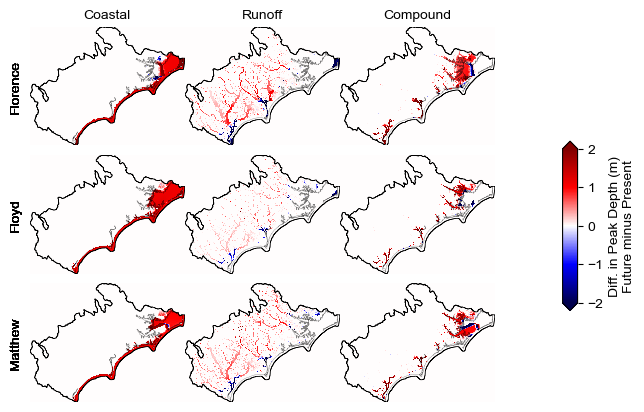

In [15]:
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(6, 5), 
                         subplot_kw={'projection': utm}, tight_layout=True, layout='constrained')
axes = axes.flatten()
counter = 0
for ax in axes:
    ckwargs = dict(cmap='seismic', vmin=-2, vmax=2)
    cs = mean_wl_diff[counter].plot(ax=ax, add_colorbar=False, **ckwargs, zorder=0)
    coastal_wb_clip.plot(ax=ax, color='none', edgecolor='black', linewidth=0.25, zorder=1, alpha=0.5)
    mod.region.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, zorder=1, alpha=1)

    ax.set_title('')
    ax.set_axis_off()
    if counter in first_row:
        ax.set_title(col_title[counter], loc='center', fontsize=10)
    for i in range(len(first_in_row)):
        axes[first_in_row[i]].text(-0.05, 0.5, row_titles[i],
                                   horizontalalignment='right',
                                   verticalalignment='center',
                                   rotation='vertical',
                                   transform=axes[first_in_row[i]].transAxes)
    counter += 1

label = 'Diff. in Peak Depth (m)\nFuture minus Present'
ax = axes[5]
pos0 = ax.get_position()  # get the original position
cax = fig.add_axes([pos0.x1 + 0.02, pos0.y0 + pos0.height * -0.2, 0.025, pos0.height * 1.2])
cbar2 = fig.colorbar(cs, cax=cax,
                     orientation='vertical',
                     label=label,
                     ticks=[-2, -1, 0, 1, 2],
                     extend='both')

plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.margins(x=0, y=0)
#plt.savefig(f'WL_diff_by_driver.png', tight_layout=True, constrained_layout=True, bbox_inches='tight', dpi=255)
#plt.close()